In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import math
import sys
sys.path.append('../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet import resnet18
from resnet_gated import resnet18_gated
from train import train_sgd, test, train_gated
from dataset import *

[0.05, 0.04351133533380851, 0.03763019350290237, 0.03233860639039575, 0.027610188407766852, 0.023412708106044778, 0.019710173577058045, 0.01646450246756338, 0.013636839516207507, 0.011188577139226377, 0.00908212776868068, 0.0072814904000044894, 0.005752648131336976, 0.004463828361377955, 0.003385652732557608, 0.0024911998332304472, 0.0017560000734507363, 0.001157978988356383, 0.0006773624649329806, 0.00029655499559261365]


In [2]:
# !pip install pretrainedmodels

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float
BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [8]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [9]:
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# model = resnet18(pretrained=False).to(device)
model_gated = resnet18_gated(pretrained=False).to(device)

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2


In [11]:
# print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
# train_sgd(model, trainloader, valloader, decay=0)

In [12]:
# correct, total = test(model, testloader)
# print('Accuracy of testthe network on test images: %0.3f %%' % (100 * correct / total))
# print('train.py finished running')

Training on 6073 examples, validating on 911 examples...
Epoch 1 of 20
Train Loss: 0.0730, Train Acc: 1.37
Val Loss: 0.0761, Val Acc: 2.85
Epoch 2 of 20
Train Loss: 0.0565, Train Acc: 24.86
Val Loss: 0.0566, Val Acc: 28.10
Epoch 3 of 20
Train Loss: 0.0481, Train Acc: 33.69
Val Loss: 0.0484, Val Acc: 38.53
Epoch 4 of 20
Train Loss: 0.0423, Train Acc: 40.18
Val Loss: 0.0426, Val Acc: 42.48
Epoch 5 of 20
Train Loss: 0.0332, Train Acc: 50.85
Val Loss: 0.0369, Val Acc: 49.40
Epoch 6 of 20
Train Loss: 0.0263, Train Acc: 60.46
Val Loss: 0.0298, Val Acc: 56.75
Epoch 7 of 20
Train Loss: 0.0203, Train Acc: 69.64
Val Loss: 0.0267, Val Acc: 62.57
Epoch 8 of 20
Train Loss: 0.0161, Train Acc: 77.49
Val Loss: 0.0246, Val Acc: 65.53
Epoch 9 of 20
Train Loss: 0.0147, Train Acc: 80.47
Val Loss: 0.0237, Val Acc: 65.64
Epoch 10 of 20
Train Loss: 0.0151, Train Acc: 78.79
Val Loss: 0.0238, Val Acc: 67.40
Epoch 11 of 20
Train Loss: 0.0146, Train Acc: 79.09
Val Loss: 0.0234, Val Acc: 64.32
Epoch 12 of 20
Trai

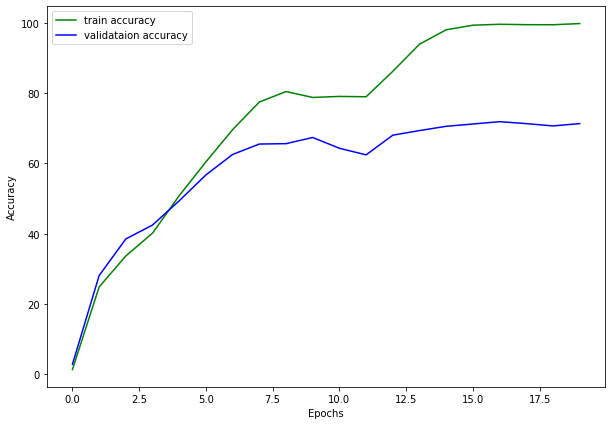

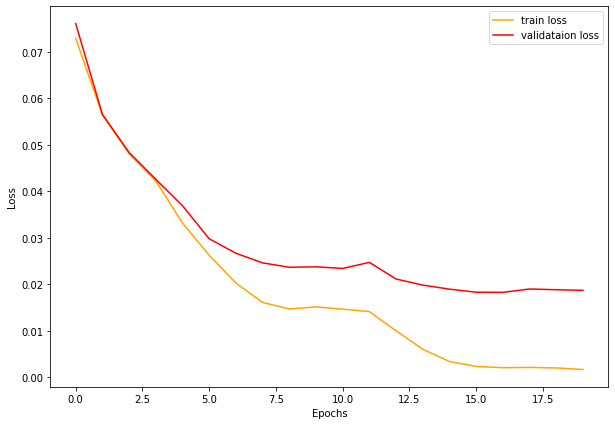

In [13]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
train_gated(model_gated, trainloader, valloader, decay=0)

In [14]:
correct, total = test(model_gated, testloader)
print('Accuracy of testthe network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of testthe network on test images: 70.408 %
train.py finished running
